# Explainable AI using SHAP

#### Problem Statement : Identify the potential customers who have a higher probability of purchasing the loan. 

This case is about a bank which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans.

#### Problem Type: Binary Classification 
##### Please note the emphasis of this notebook is to demonstrate the use of SHAP, so we will not be focusing on other aspects of ML such as EDA, Model Training & Optmization Process etc.


## Dataset : 

Data is taken from the kaggle dataset - # https://www.kaggle.com/itsmesunil/bank-loan-modelling#

In [1]:
!pip install shap

In [5]:
import shap
import pandas as pd

### Exploratory Data Analysis 
##### There are 12 features. The aim is to construct a model that can identify potential customers who has higher probability of purchasing loan.
#### 0 - Non-Loan customers
#### 1 - Loan customers


### 2. Loading the dataset

In [101]:
loan_data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
#for more convinient - reposition "Personal Loan"  column since it is our target column for research
temp = loan_data['Personal Loan']
loan_data.drop('Personal Loan', axis = 1, inplace = True)
loan_data['Personal Loan'] = temp
loan_data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,1,25,1,49,91107,4,1.6,1,0,1,0,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,1,0,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,1,0


### Variables definition


> - **ID** - Customer ID 
> - **Age** - Customer's age in completed years 
> - **Experience** - #years of professional experience 
> - **Income** - Annual income of the customer - in thousands usd 
> - **ZIPCode** - Home Address ZIP code. 
> - **Family** - Family size of the customer 
> - **CCAvg** - Avg. spending on credit cards per month - in thousands usd 
> - **Education** - Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional 
> - **Mortgage** - Value of house mortgage if any - in thousands usd  
> - **Personal Loan**  - Did this customer accept the personal loan offered in the last campaign? 
> - **Securities Account** - Does the customer have a securities account with the bank? 
> - **CD Account** - Does the customer have a certificate of deposit (CD) account with the bank? 
> - **Online** - Does the customer use internet banking facilities? 
> - **CreditCard** - Does the customer uses a credit card issued by UniversalBank?



# Assess Data

In [104]:
#check for the null values
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
 13  Personal Loan       5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [103]:
loan_data.nunique()

ID                    5000
Age                     45
Experience              47
Income                 162
ZIP Code               467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Securities Account       2
CD Account               2
Online                   2
CreditCard               2
Personal Loan            2
dtype: int64

> **Observation**
> - No null values
> - No missing values
> - Columns "ID", "ZIP Code" are categorical nominal variables. Should be in 'str' type

In [102]:
loan_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Securities Account,5000.0,0.104400,0.305809,0.0,0.00,0.0,0.00,1.0


> **Observation**
> - Column "Experience" has some negative value. Need to fix
> - Binary variables "Personal Loan", "CreditCard", "Online", "CD Account", "Securities Account" has clean data
> - Ordinary Cat variables "Family" and "Education" are clean too  

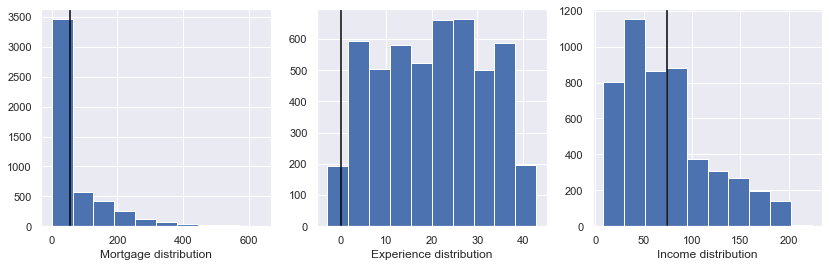

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
cols = ['Experience', 'Mortgage']
fig, [ax0, ax1, ax2] = plt.subplots(1,3, figsize = (14,4))

ax0.hist(loan_data.Mortgage)
ax0.set_xlabel('Mortgage distribution')
ax0.axvline(loan_data.Mortgage.mean(), color = "black")

ax1.hist(loan_data.Experience)
ax1.set_xlabel('Experience distribution')
ax1.axvline(0, color = "black");

ax2.hist(loan_data.Income)
ax2.set_xlabel('Income distribution')
ax2.axvline(loan_data.Income.mean(), color = "black");

### Summary Assess Data
> - Columns "ID", "ZIP Code" are nominal variables. Should be in 'str' type
> - Column "Experience" has some negative value. Need to fix

No bad tidiness issues

### Replace nagative 'Experience' values with the means

In [111]:

#check the ammount of negative values
loan_data[loan_data['Experience'] < 0]['Experience'].value_counts()

indexes = loan_data[loan_data['Experience'] < 0].index.tolist()
for i in indexes:
     loan_data.loc[i,'Experience'] = loan_data[(loan_data.Experience > 0)].Experience.mean()
        
loan_data.Experience.describe()        

count    5000.000000
mean       20.333901
std        11.253020
min         0.000000
25%        11.000000
50%        20.605899
75%        30.000000
max        43.000000
Name: Experience, dtype: float64

In [112]:
#ID won't be a valuable feature
loan_data.drop(columns = "ID", inplace = True)

## Data Exploration

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


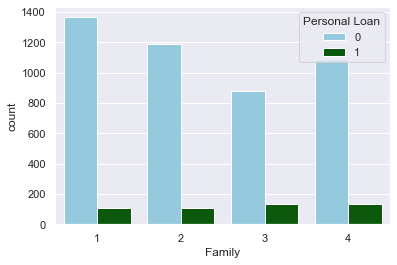

In [150]:
# A function that returns value counts for a column split by personal_loan
def groupby_get_cc_count(tdf, col):
    tdf = tdf.groupby([col, "Personal Loan"])["Personal Loan"].count().reset_index(level = 0)
    tdf.columns = [col, "count"]
    tdf = tdf.reset_index()
    return tdf


xx = df["Family"].value_counts().reset_index()
xx["index"] = xx["index"].astype(str)
xx["family_perc"] = xx["Family"].apply(lambda x : round((x/5000)*100, 2))
# create_donut(*(1, xx.iloc[0]["family_perc"], xx.iloc[1]["family_perc"], xx.iloc[2]["family_perc"], xx.iloc[3]["family_perc"], 4))      # Create a donut chart each family size


# Create a bar chart showing count of family grouped by size and split by personal_loan
plt.subplot(1, 1, 1)
xx = groupby_get_cc_count(df[["Family", "Personal Loan"]], "Family")
sns.barplot(xx["Family"], xx["count"], hue = xx["Personal Loan"], palette = ["skyblue", "darkgreen"]);
plt.show();


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


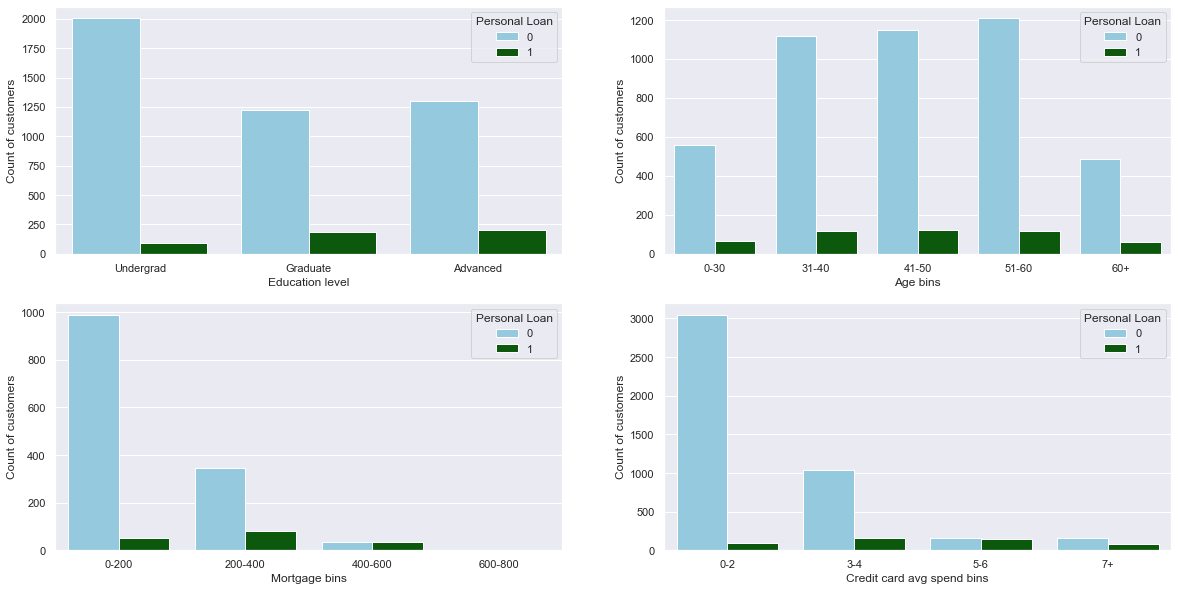

In [151]:
fig, axes = plt.subplots(2, 2, figsize = (20,10))
# Distribution of Education
xx = groupby_get_cc_count(loan_data[["Education", "Personal Loan"]], "Education")
d_dict = {1 : "Undergrad", 2 : "Graduate", 3 : "Advanced"}
xx["degree"] = xx["Education"].apply(lambda x : d_dict[x])
ax = sns.barplot(xx["degree"], xx["count"], hue = xx["Personal Loan"], ax = axes[0][0], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Education level', ylabel = 'Count of customers');

# Distribution of Age
df['age_bin'] = pd.cut(loan_data['Age'], bins = [0, 30, 40, 50, 60, 100], labels = ['0-30', '31-40', '41-50', '51-60', '60+'])
xx = groupby_get_cc_count(df[["age_bin", "Personal Loan"]], "age_bin")
ax = sns.barplot(xx["age_bin"], xx["count"], hue = xx["Personal Loan"], ax = axes[0][1], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Age bins', ylabel = 'Count of customers');

# Distribution of Mortgage
df['mtg_bin'] = pd.cut(loan_data['Mortgage'], bins = [0, 200, 400, 600, 800], labels = ['0-200', '200-400', '400-600', '600-800'])
xx = groupby_get_cc_count(df[["mtg_bin", "Personal Loan"]], "mtg_bin")
ax = sns.barplot(xx["mtg_bin"], xx["count"], hue = xx["Personal Loan"], ax = axes[1][0], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Mortgage bins', ylabel = 'Count of customers');

# Distribution of CCAvg
df['ccavg_bin'] = pd.cut(loan_data['CCAvg'], bins = [0, 2, 4, 6, 100], labels = ['0-2', '3-4', '5-6', '7+'])
xx = groupby_get_cc_count(df[["ccavg_bin", "Personal Loan"]], "ccavg_bin")
ax = sns.barplot(xx["ccavg_bin"], xx["count"], hue = xx["Personal Loan"], ax = axes[1][1], palette= ["skyblue", "darkgreen"]);
ax.set(xlabel = 'Credit card avg spend bins', ylabel = 'Count of customers');

**Observations:**

- **Family** : Grouping it by **personal_loan** shows that the number of personal loans taken by a **family of 4** is the highest. There is an interesting pattern that shows larger families feel a need to get personal loans more.

- **Education** : Most of the customers are undergraduates. There are more number of customers who have taken a personal_loan and Education level of Advanced followed by Graduates and Undergrads being the lowest which suggests that higher the education level the more the customer is confident and open to opt for **personal_loan**. 

- **Age**: There are a lot of people in the age range of 51-60 but people in the age bracket of 41-50 have the highest number of customers with a personal loan.

- **Mortgage** : Majority of the customers are in the 0-200 mortgage bin but the number of people with personal loan is the highest in the 200-400 bin.

- **CCAvg** : More than 50% of the customers have an average credit card spend in the range of 0-2 but has a very less number of people with personal_loan as compared to other bins. The customers with average credit card spend of 3-4 and 5-6 have a lot of customers who have taken a personal loan

<hr>

### Since the intent is to predict personal loan, i.e. 1 if the loan is accepted, 0 if it isn't.
## - Separate the dataset into target variable and features

In [113]:

y = loan_data['Personal Loan']
X = loan_data.drop(columns=['Personal Loan'], inplace = False)

## - Train-test Split

In [114]:
from sklearn.model_selection import train_test_split
#let us split the dataset into train (80%) and test sample (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Let us save column names, as they later will be feature names
columns = X_train.columns
columns

Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online',
       'CreditCard'],
      dtype='object')

Let us run a well known model that often fits very well to training data, Random Forest.

## - Model Training

In [152]:
from sklearn.ensemble import RandomForestClassifier

#fit the model based on the given training samples
rf_model=RandomForestClassifier(random_state=20)
rf_model.fit(X_train, y_train)

#get the accuracy of the model
rf_model.score(X_test, y_test)

0.99

That's an extremely well fitting model, which often isn't the case in real-life examples. But over-fitting, or model accuracy isn't our intention for this exercise.

# SHapley Additive exPlanations

### we need an instance of explainer for a tree-based model, i.e. our random forest (rf)
### Explainers are in-built methods of these libraries, customisable by the attributes they can take in

In [185]:
import shap
explainer = shap.TreeExplainer(rf_model) 
shap_values = explainer.shap_values(X_test.iloc[1]) #pass the first test sample, to see what influenced the first value. we can iterate for other values as well.

In [189]:
# base value for class 1 ie accepting the loan class 
print("base-valuee : {}".format(explainer.expected_value[1]))
print(X_test.iloc[1])

base-valuee : 0.09408000000000001
Age                      47.0
Experience               23.0
Income                  149.0
ZIP Code              92675.0
Family                    4.0
CCAvg                     6.1
Education                 1.0
Mortgage                  0.0
Securities Account        0.0
CD Account                0.0
Online                    0.0
CreditCard                1.0
Name: 2586, dtype: float64


<img src="img/img_1.png" alt="Drawing" style="width: 700px;"/>

# Individual SHAP Value Plot — Local Interpretability
## shap.force_plot

In [157]:
shap.initjs() #to make the visualization happen in the notebook environment
shap.force_plot(explainer.expected_value[1], shap_values=shap_values[1], features=X_test.iloc[1])


## Let us understand SHAP output 
1. Features in red color are pushing value higher, to make it equal to the prediction current class.
2. Features in blue color are pushing value lower, i.e away from our current class.
3. Current class: Since current class "Personal loan" value is 1, i.e loan  accepted, we can see red features are the ones pushing our prediction to 1, blue ones to 0.
4. The larger the feature block, the more important it is. 
5. Visually juding, since red overpowers blue, our predicton also called it a 1, i.e loan accepted. 



## Individual SHAP Value Plot — Local Interpretability

### shap.waterfall_plot


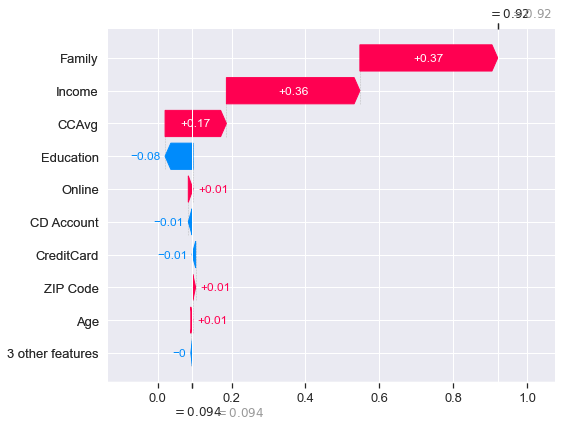

In [158]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1], show = True, feature_names = columns)

In [91]:
print(X_test.iloc[5])
shap.initjs() #to make the visualization happen in the notebook environment
shap.force_plot(explainer.expected_value[1], shap_values=shap_values[1][5], features=X_test.iloc[5])

Age                      43.0
Experience               17.0
Income                   69.0
ZIP Code              92717.0
Family                    4.0
CCAvg                     2.9
Education                 1.0
Mortgage                  0.0
Securities Account        0.0
CD Account                0.0
Online                    1.0
CreditCard                1.0
Name: 106, dtype: float64


In [160]:
#Let us pass the whole dataset now, and see which attribute interacts the most
#create an explainer for a tree-based model, i.e., random forest (rf)
explainer_gl = shap.TreeExplainer(rf_model) 
shap_values_gl = explainer_gl.shap_values(X_test)#passing the entire dataset

## Sumary Plot — Global Interpretability

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.¶

SHAP summary plot. Low income increase the chance of not taking loan.

In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.

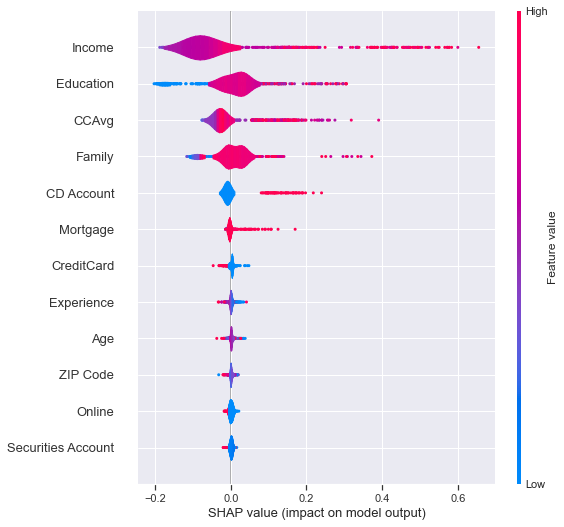

In [161]:
shap.summary_plot(shap_values_gl[1], X_test, plot_type='violin', plot_size=0.6)

This plot shows all the data points in test data. Following can be concluded from this plot.

1. The graph displays important features in descending order. Most important features are the top.

2. The poistion of a point is associated with the impact of that particular value on the model.

3. Red colour indicates a higher value and blue indicates lower value. 

4. We remember red pushes value of probability of current class higher and towards current class. So, higher the income, higher the chances of current class, ie 1.

4. For eg: Median to High value of education also increases the probability of current class.. 

In [164]:
# print(len(shap_values))
#1000 -> Total Customers in X_test and 11 -> Total Features
shap_values_gl[1].shape

(1000, 12)

# SHAP Feature Importance
The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we sum the absolute Shapley values per feature across the data:

Next, we sort the features by decreasing importance and plot them. The following figure shows the SHAP feature importance for the random forest trained before for predicting loan accepted.

<AxesSubplot:>

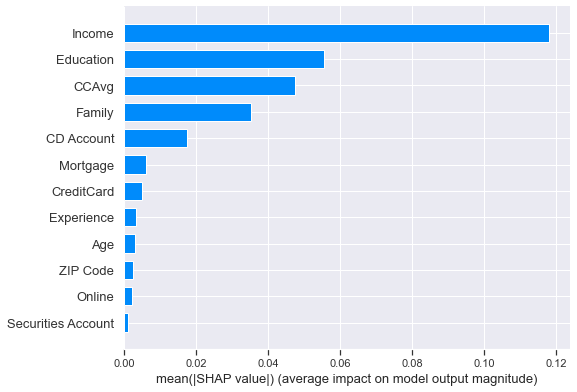

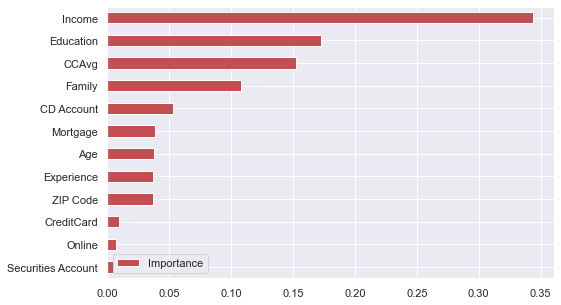

In [184]:
shap.summary_plot(shap_values_gl[1], X_test, plot_type = "bar", show = False)

Importance = pd.DataFrame({'Importance':rf_model.feature_importances_}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8, 5) )

SHAP feature importance measured as the mean absolute Shapley values. 
Income was the most important feature, changing the predicted absolute of taking loan on average by 12 percentage points (0.12 on x-axis).

The feature importance plot is useful, but contains no information beyond the importances.

<img src="img/img.png" alt="Drawing" style="width: 600px;"/>

## SHAP Dependence Plot
SHAP feature dependence might be the simplest global interpretation plot: 1) Pick a feature. 2) For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis. 3) Done.

#dependence_plot()method:
#shap.dependence_plot(<name of feature with what we want to find the relation of target variable>, <which SHAP value we want to consider(can be randomly any)>, <dataset>)

The following figure shows the SHAP feature dependence for years on hormonal contraceptives:

FIGURE 9.27: SHAP dependence plot for years on hormonal contraceptives. Compared to 0 years, a few years lower the predicted probability and a high number of years increases the predicted cancer probability.

SHAP dependence plots are an alternative to partial dependence plots and accumulated local effects. While PDP and ALE plot show average effects, SHAP dependence also shows the variance on the y-axis. Especially in case of interactions, the SHAP dependence plot will be much more dispersed in the y-axis. The dependence plot can be improved by highlighting these feature interactions.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


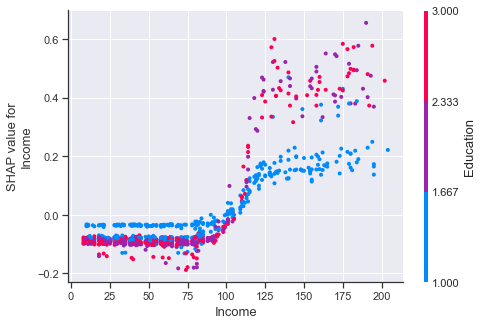

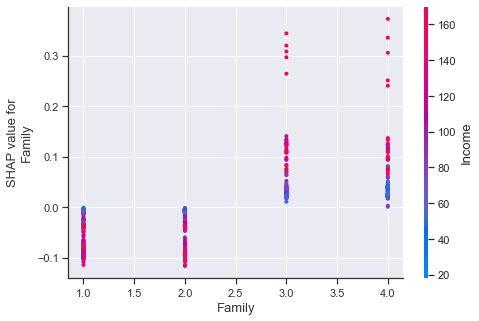

In [170]:

shap.dependence_plot("Income", shap_values_gl[1], X_test)
shap.dependence_plot("Family", shap_values_gl[1], X_test)

We observe as the income increases, SHAP value of income increases.
What does it mean?
Higher the income, hiher the chances of being closer to current class, i.e 1 (accepting the Loan)

Higher the income, higher the chances of  accepting the loan.

Let us see the whole data features and their impact at once

**Observations:**

- It seems the customers whose education level is 1 is having more income. However customers who has taken the personal loan have the same income levels

- Customers who does not have CD account , does not have loan as well. This seems to be majority. But almost all customers who has CD account has loan as well

- Customers who have personal loan have a higher credit card average. Average credit card spending with a median of 3800 dollar indicates a higher probability of personal loan. Lower credit card spending with a median of 1400 dollars is less likely to take a loan. This could be useful information.


**If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in shap.TreeExplainer(my_model). But the SHAP package has explainers for every type of model.**

- shap.DeepExplainer works with Deep Learning models.
- shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

- Here is an example using KernelExplainer to get similar results. The results aren't identical because KernelExplainer gives an approximate result. But the results tell the same story.


In [ ]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(rf_model.predict_proba, X_test)
k_shap_values = k_explainer.shap_values(X_test)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1][1], X_test.iloc[1])

#Benefits:
1. With SHAP we could tell which feature is more important
2. Impact of a particular feature on one target variable or the whole dataset as well